In [1]:
import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt

from scipy.stats import norm

import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

np.set_printoptions(suppress=True)

from __Function__ import *

np.random.seed(42)

# Importing Data

In [2]:
path = r'C:\Users\baris\Desktop\Master Thesis\1. Python\Data\Option_Calibration_SPX_18072025_WMC.csv'
df = pd.read_csv(path, index_col=None)
spx_price = 6296.79

# Calibration of the Weighted Monte Carlo under Heston Model

In [ ]:
def simulate_heston(S0, V0, r, kappa, theta, sigma_v, rho, N, N_steps):
    dt = 1/252 # Amplitude of step
    epsilon = 1e-10
    S = np.zeros((N, N_steps + 1))
    V = np.zeros((N, N_steps + 1))
    S[:, 0] = S0
    V[:, 0] = V0
    for t in range(1, N_steps + 1):
        Z1 = np.random.randn(N)
        Z2 = rho * Z1 + np.sqrt(1 - rho**2) * np.random.randn(N)
        V_prev = np.maximum(V[:, t - 1], 0)
        V[:, t] = V_prev + kappa * (theta - V_prev) * dt + sigma_v * np.sqrt(V_prev + epsilon) * np.sqrt(dt) * Z2
        V[:, t] = np.maximum(V[:, t], 0)
        S[:, t] = S[:, t - 1] * np.exp((r - 0.5 * V_prev) * dt + np.sqrt(V_prev + epsilon) * np.sqrt(dt) * Z1)
    return S

In [4]:
S0 = spx_price
r = 0.0408 # data from 18 july 2025
T_max = np.max(df['Maturity'].to_numpy('float'))
market_prices = df['Price'].to_numpy('float')
strikes = df['Strike'].to_numpy('float')
average_IV = df['IV'].mean()

kappa = 1.5
rho = -0.5
volvol = 0.6
theta = 0.03
var0 = df['IV'].mean() ** 2

In [5]:
dates = sorted(set(df['Maturity'])) # Sort maturity 
dates_day = np.array([int(np.ceil(date * 252)) for date in dates]) # Convert the maturity to number of steps

dt = 1/252 # Amplitude of step
N_paths = 50_000 # Number of path
N_steps = int(np.ceil(T_max / dt)) # Max number of needed step

In [6]:
simulated_prices = simulate_heston(S0, var0, r, kappa, theta, volvol, rho, N_paths, N_steps)
discount_factor = np.exp(-r*np.array(dates)) # The discount factor for different maturity

In [7]:
g=np.array(np.zeros(shape=(N_paths, len(df))))    # initialize payoff matrix (V x N) 
C=np.zeros(shape=(len(df)))                       # initialize price vector (N)

In [8]:
# Calculate the PV of payoffs for all the instruments
time_list = sorted(set(df['Maturity']))

for i, row in enumerate(df.values):
    time_index = time_list.index(row[0])
    date_index = dates_day[time_index]
    if df['Strike'][i] == 0:
        g[:, i] = (row[2] - simulated_prices[:, date_index]) * discount_factor[time_index]
        C[i]=row[1]
    else:
        g[:, i] = np.maximum((simulated_prices[:, date_index] - row[1]), 0) * discount_factor[time_index]
        C[i]=row[2]

In [9]:
print("payoff:", g.shape)
print("market_prices:", np.array(market_prices).shape)

payoff: (50000, 36)
market_prices: (36,)


In [10]:
# Normalisation
g_normalize = g / spx_price
C_normalize = C / spx_price

In [11]:
w = WMC(g_normalize, C_normalize)
w.solve(options={'maxiter': 1e6, 'ftol': 1e-12}, e=1e-5, fPrime=True)
w.opt_result

  message: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
  success: True
   status: 0
      fun: 10.634372221159088
        x: [-3.751e+01  3.431e+01 ...  3.730e+00 -3.336e+00]
      nit: 103
      jac: [-7.208e-06 -8.509e-06 ...  9.187e-06  1.462e-06]
     nfev: 121
     njev: 121
 hess_inv: <36x36 LbfgsInvHessProduct with dtype=float64>

In [12]:
WMC_lambda = w.lambda_ # Store lambda values
WMC_weights = np.array(w.p).flatten() # Store optimal weights

In [13]:
g_WMC = np.array(np.zeros(shape=(N_paths, len(df))))  
C_WMC = np.zeros(shape=(len(df)))

In [14]:
# Calculate the PV of payoffs for all the instruments with the WMC calibration
time_list = sorted(set(df['Maturity']))

for i, row in enumerate(df.values):
    time_index = time_list.index(row[0])
    date_index = dates_day[time_index]
    if df['Strike'][i] == 0:
        g_WMC[:, i] = (simulated_prices[:, date_index] * WMC_weights).sum()
        C_WMC[i] = g_WMC[:, i].mean()
    else:
        g_WMC[:, i] = np.maximum(((simulated_prices[:, date_index] - row[1]) * WMC_weights), 0).sum() * discount_factor[time_index]
        C_WMC[i] = g_WMC[:, i].mean()

In [15]:
df['WMC_Heston'] = C_WMC
df['Error'] = abs((df['WMC_Heston'] - market_prices))

In [16]:
df['Error'].mean(), df['Error'].median()

(np.float64(0.8508557624315682), np.float64(0.4256459985741081))

# Summary of the Weighted Monte Carlo Calibration under Heston 

In [17]:
# Import the full data to compare how good is our calibrated BS model
path = r'C:\Users\baris\Desktop\Master Thesis\1. Python\Data\Option_Data_SPX_18072025.csv'  
df_pricing = pd.read_csv(path, index_col=None)[['Maturity', 'Strike', 'Price']] 

In [18]:
strikes_pricing = df_pricing['Strike'].to_numpy('float')
maturity_pricing = df_pricing['Maturity'].to_numpy('float')

dates = sorted(set(df_pricing['Maturity']))
discount_factor = np.exp(-r*np.array(dates)) 

In [19]:
g_WMC = np.array(np.zeros(shape=(N_paths, len(df_pricing))))    # initialize payoff matrix  (V x N) 
C_WMC = np.zeros(shape=(len(df_pricing)))                       # initialize price vector (N)

In [20]:
# Calculate the PV of payoffs for all the instruments
time_list = sorted(set(df_pricing['Maturity']))
dates_day = np.array([int(np.ceil(date * 252)) for date in dates])

for i, row in enumerate(df_pricing.values):
    time_index = time_list.index(row[0])
    date_index = dates_day[time_index]
    g_WMC[:, i] = np.maximum(((simulated_prices[:, date_index] - row[1]) * WMC_weights), 0).sum() * discount_factor[time_index]
    C_WMC[i]= g_WMC[:, i].mean()

In [21]:
df_pricing['WMC_Heston'] = g_WMC.mean(axis=0)
df_pricing['Error'] = abs((df_pricing['WMC_Heston'] - df_pricing['Price']))

In [22]:
maturity_error = Comparaison.comparaison_maturity(df_pricing)
maturity_error

,Metric Maturity,Mean Eror (abs)
0,"Mean (Filtered for maturity < 0.3, Price = 143...",3.3016
1,"Mean (Filtered for maturity >= 0.3 and < 0.6, ...",4.8428
2,"Mean (Filtered for maturity >= 0.6, Price = 35...",7.3273


In [23]:
strike_error = Comparaison.comparaison_strike(df_pricing, spx_price)
strike_error

,Metric Strike,Mean Eror (abs)
0,"Mean (Filtered for strike < 100, Price = 357.6...",8.2710
1,"Mean (Filtered for strike >= 100 and < 105, Pr...",3.4760
2,"Mean (Filtered for strike >= 105, Price = 75.9...",1.4785


In [24]:
surface_error = Comparaison.comparaison_surface(df_pricing)
surface_error

,Metric Surface,Mean Eror (abs)
0,"Mean (Filtered for price < 81.70$, 20% Quantile)",0.8335
1,"Mean (Filtered for price > 81.70$, 20% Quantile)",5.7189
2,"Mean (Filtered for price > 214.65$, 50% Quantile)",7.7176
3,"Mean (Filtered for price > 370.98$, 80% Quantile)",8.9573
4,Mean,4.7169
5,Median,2.0224


In [25]:
N = len(WMC_weights)
u = np.full(N, 1/N)
D_pu = np.sum(WMC_weights * np.log((WMC_weights + 1e-16) / u))
print("Relative entropy D(p||u):", D_pu)

alpha = 1 - D_pu / np.log(N)
print("Alpha :", alpha)

nu_star = N**alpha
print("Nombre effectif de paths nu* :", nu_star)
print("Fraction du total :", nu_star / N)

Relative entropy D(p||u): 0.10827879926621628
Alpha : 0.9899925121920261
Nombre effectif de paths nu* : 44868.8686698917
Fraction du total : 0.897377373397834


In [26]:
df_stats = Comparaison.stats_weights(WMC_weights)
df_stats

,Statistic,Value
0,Mean,2e-05
1,Standard Error,4.38437e-08
2,Median,1.91026e-05
3,Mode,8.19925e-07
4,Standard Deviation,9.80374e-06
5,Sample Variance,9.61133e-11
6,Kurtosis,11.7994
7,Skewness,1.87144
8,Range,0.000161094
9,Minimum,8.19925e-07


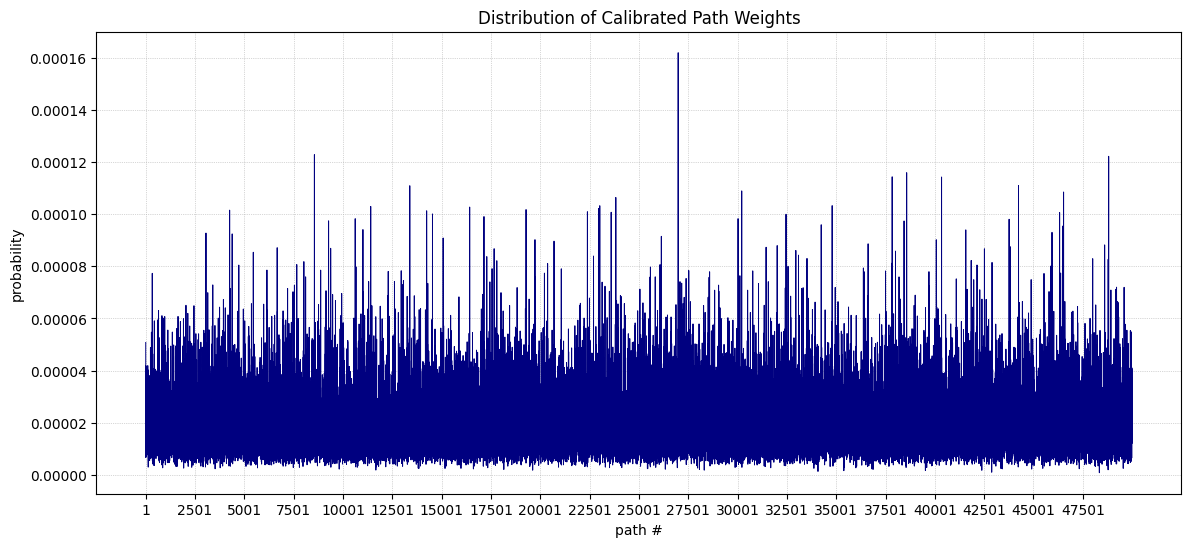

In [27]:
N = len(np.array(w.p).flatten())
x = np.arange(1, N+1)

plt.figure(figsize=(14, 6))
plt.plot(x, np.array(w.p).flatten(), color='navy', linewidth=0.7)
plt.xlabel('path #')
plt.ylabel('probability')
plt.title('Distribution of Calibrated Path Weights')

tick_spacing = max(1, N // 20)

plt.xticks(np.arange(1, N+1, tick_spacing))
plt.grid(True, linestyle=':', linewidth=0.5)
plt.savefig(r"C:\Users\baris\Desktop\Master Thesis\2. Writing\Heston\WMC_Heston_distribution_weights.png", dpi=300, bbox_inches='tight')

In [28]:
Comparaison.saving_data(maturity_error, 'Heston\WMC_Heston_maturity_error')
Comparaison.saving_data(strike_error, 'Heston\WMC_Heston_strike_error')
Comparaison.saving_data(surface_error, 'Heston\WMC_Heston_surface_error')
Comparaison.saving_data(df_stats, 'Heston\WMC_Heston_recap_stat')

# TEST WMC-Heston One Maturity

In [29]:
S0 = spx_price
r = 0.03 # data from 18 july 2025
T_max = np.max(df['Maturity'].to_numpy('float'))
market_prices = df[df['Maturity'] == T_max]['Price'].to_numpy('float')
strikes = df[df['Maturity'] == T_max]['Strike'].to_numpy('float')
average_IV = df[df['Maturity'] == T_max]['IV'].mean()

kappa = 1.5
rho = -0.5
volvol = 0.6
theta = 0.03
var0 = average_IV ** 2

In [30]:
dt = 1/252 # Amplitude of step
N_paths = 50_000 # Number of path
N_steps = int(np.ceil(T_max / dt)) # Max number of needed step

In [31]:
T_max

np.float64(0.742465753)

In [32]:
S = simulate_heston(S0, var0, r, kappa, theta, volvol, rho, N_paths, N_steps)
S_T = S[:,-1]

In [33]:
g=np.array(np.zeros(shape=(N_paths, len(market_prices))))    # initialize payoff matrix (V x N) 
C=np.zeros(shape=(len(market_prices)))                       # initialize price vector (N)

In [34]:
i = 0
for strike in strikes:
    g[:, i] = np.maximum((S_T - strike), 0) * np.exp(-r*T_max)
    C[i]=market_prices[i]
    i += 1

In [35]:
# Normalisation
g_normalize = g / S0
C_normalize = C / S0

In [36]:
w = WMC(g_normalize, C_normalize)
w.solve(e=0, options={'maxiter': 1e6, 'ftol': 1e-12}, fPrime=True)
w.opt_result

  message: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
  success: True
   status: 0
      fun: 10.457329802989278
        x: [-1.578e+02  1.413e+02 -1.367e+02  1.625e+02 -7.483e+01
             6.341e+01]
      nit: 37
      jac: [ 4.060e-06  3.989e-06  3.413e-06  2.034e-06  6.323e-07
             4.234e-06]
     nfev: 43
     njev: 43
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>

In [37]:
WMC_lambda = w.lambda_ # Store lambda values
WMC_weights = np.array(w.p).flatten() # Store optimal weights

In [38]:
g_WMC = np.array(np.zeros(shape=(N_paths, len(market_prices))))  
C_WMC = np.zeros(shape=(len(market_prices)))

In [39]:
i = 0
for strike in strikes:
    g_WMC[:, i] = np.maximum(((S_T - strike) * WMC_weights), 0).sum() * np.exp(-r*T_max)
    C_WMC[i]= g_WMC[:, i].mean()
    i += 1

In [40]:
df_numeric = pd.DataFrame()

df_numeric['WMC_Heston'] = np.round(C_WMC, 4)
df_numeric['Market Price'] = np.round(market_prices, 4)
df_numeric['Error (abs)'] = np.round(abs((df_numeric['WMC_Heston'] - market_prices)), 4)

In [41]:
df_numeric['Error (abs)'].mean(), df_numeric['Error (abs)'].median()

(np.float64(0.019266666666666668), np.float64(0.0233))

In [42]:
df_numeric

,WMC_Heston,Market Price,Error (abs)
0,636.2256,636.2000,0.0256
1,488.9051,488.8800,0.0251
2,295.6415,295.6200,0.0215
3,206.7228,206.7100,0.0128
4,129.1740,129.1700,0.0040
5,6490.4813,6490.4547,0.0266


In [43]:
fig = go.Figure(data=[go.Table(
    header=dict(
        values=[f"<b>{col}</b>" for col in df_numeric.columns],
        fill_color="#2e6b57",
        font=dict(color='white', size=12),
        align='center',
        height=40),
        
        cells=dict(
            values=[df_numeric[df_numeric.columns[0]], df_numeric[df_numeric.columns[1]], df_numeric[df_numeric.columns[2]]],
            fill_color='#f5f5fa',
            align='center',
            font_size=11,
            height=32)
            )])

fig.update_layout(width=2500, height=500, margin=dict(l=0, r=0, t=0, b=0))
fig.write_image(fr"C:\Users\baris\Desktop\Master Thesis\2. Writing\Heston\WMC_Heston_One_Maturity.png", scale=3)

# Implied Volatility

## One Maturity

In [44]:
def bs_price_call(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)

def bs_vega(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma * np.sqrt(T))
    return S * norm.pdf(d1) * np.sqrt(T)

def implied_vol_newton(price, S, K, T, r, tol=1e-8, max_iterations=100):
    sigma = 0.2 # Initial guess
    for i in range(max_iterations):
        price_bs = bs_price_call(S, K, T, r, sigma)
        vega = bs_vega(S, K, T, r, sigma)
        price_diff = price_bs - price
        if abs(price_diff) < tol:
            return sigma
        sigma -= price_diff / vega
        sigma = max(sigma, 1e-8) # Security to avoid 0
    return sigma #If no convergence, return the last value

In [45]:
IV_WMC_Heston = []
IV_Market = []
r = 0.0408

for price_WMC, price, strike in zip(df_numeric['WMC_Heston'], market_prices, strikes):
    IV_WMC_Heston.append(implied_vol_newton(price_WMC, spx_price, strike, T_max, r))
    IV_Market.append(implied_vol_newton(price, spx_price, strike, T_max, r))

df_numeric['IV_WMC_Heston'] = IV_WMC_Heston
df_numeric['IV_Market'] = IV_Market
df_numeric['Strike'] = strikes

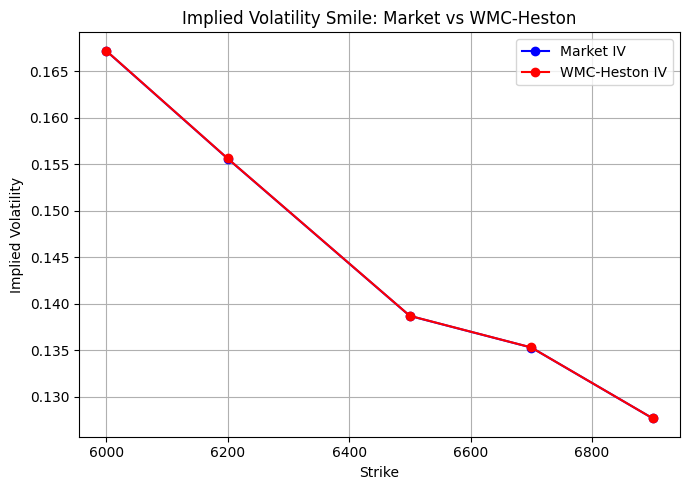

In [46]:
# Filtrer les lignes où IV ou IV_Heston est égal à zéro
df_plot = df_numeric[(df_numeric['IV_Market'] > 0.001) & (df_numeric['IV_WMC_Heston'] > 0.001)]

plt.figure(figsize=(7, 5))

plt.plot(df_plot['Strike'], df_plot['IV_Market'], marker='o', label='Market IV', color='blue')
plt.plot(df_plot['Strike'], df_plot['IV_WMC_Heston'], marker='o', label='WMC-Heston IV', color='red')

plt.xlabel("Strike")
plt.ylabel("Implied Volatility")
plt.title("Implied Volatility Smile: Market vs WMC-Heston")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(r"C:\Users\baris\Desktop\Master Thesis\2. Writing\Heston\WMC_Heston_IV_One_Maturity.png", dpi=300, bbox_inches='tight')

## Surface Volatility 

In [47]:
IV_WMC_Heston = []
IV = []
r = 0.0408

for price, price_WMC, strike, maturity in zip(df_pricing['Price'], df_pricing['WMC_Heston'], df_pricing['Strike'], df_pricing['Maturity']):
    IV_WMC_Heston.append(implied_vol_newton(price_WMC, spx_price, strike, maturity, r))
    IV.append(implied_vol_newton(price, spx_price, strike, maturity, r))


df_pricing['IV_WMC_Heston'] = IV_WMC_Heston
df_pricing['IV'] = IV

In [48]:
import plotly.graph_objs as go

# Filtrer les lignes où IV ou IV_Heston est égal à zéro
df_plot = df_pricing[(df_pricing['IV'] > 0.001) & (df_pricing['IV_WMC_Heston'] > 0.001)]

fig = go.Figure()

# Market IV as Mesh
fig.add_trace(go.Mesh3d(x=df_plot['Maturity'], y=df_plot['Strike'], z=df_plot['IV'],
                        color='blue',
                        opacity=0.4,
                        name='Market IV'))

# Heston IV as Markers
fig.add_trace(go.Scatter3d(x=df_plot['Maturity'], y=df_plot['Strike'], z=df_plot['IV_WMC_Heston'],
                           mode='markers',
                           marker=dict(size=7, color='red'),
                           name='WMC Heston IV'
                           ))

fig.update_layout(title_text="Market Implied Volatility Surface (Mesh) vs Calibrated Heston IV (Markers)",
                  scene=dict(xaxis_title='MATURITY', yaxis_title='STRIKE', zaxis_title='IMPLIED VOLATILITY'),
                  width=1200,
                  height=1000,
                  legend=dict(x=0.05, y=0.95))

fig.show()